In [1]:
# make sure openbabel is installed! although should be installed as pymatgen dependency..?
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.cif import CifParser
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.io.xyz import XYZ
from pymatgen.io.gaussian import GaussianInput
import numpy as np
import os
from string import Template
from matplotlib import pyplot as plt
from rob_siesta_utils import write_siesta_inputs

# For indexing/tagging species in SIESTA
species_index_dict = {
    'C': 1,
    'Li': 2
}

# For adding chemical species labels in SIESTA
species_labels_dict = {
    'C': f"{species_index_dict['C']} 6  C-gga",
    'Li': f"{species_index_dict['Li']} 3  Li-gga"
}

### Define our strains (z-axis) and generate structures with pymatgen

Note: need to read in .cif files here

In [20]:
# define strains
strains = np.arange(-0.5, 0.5, 0.02)
xyz_path = "./testing/xyz/"
fdf_path = "./testing/fdf/"

# generate strained structures
structures = {}
for strain in strains:
    LiC6 = Structure.from_file('../Pristine_primitiveStructure/LiC6.primitive.cif')
    # LiC6.make_supercell([2,2,2])
    LiC6.apply_strain([0, 0, strain])
    structures[strain] = LiC6

c = structures[strains[25]].lattice.c
z_distance = [c * (1+s) for s in strains]
print(c)

3.699860000000002


### Create XYZ-trajectory file to visually represent the strains we are scanning

In [3]:
# write xyz trajectory for strained structures to visualize
# visually validate with VMD
for strain in strains:
    xyz = XYZ(structures[strain])
    name = f"{xyz_path}LiC6_strained_{round(strain,2)}.xyz"
    xyz.write_file(name)
    test_trj = f"{xyz_path}LiC6_trj.xyz"
    os.system(f"cat {name} >> {test_trj}")
    os.system(f"echo '\n' >> {test_trj}")

os.system(f"obabel {test_trj} -O {xyz_path}babtrj_LiC6.xyz")

50 molecules converted


0

### Write SIESTA input files using desired mesh density and basis set

Sampling SZ, SZP, DZ, DZP @ k = 2, 3, 4

In [4]:
def create_siesta_inputs(system_name, basis, k, head_template, tail_template):
    
    fdf_path = f"./{system_name}_scan/{basis}_k{k}/inputs/"

    os.system(f'mkdir -p {fdf_path}')
    
    print(fdf_path)

    n_atoms = structures[strains[0]].num_sites
    n_species = len(set(structures[strains[0]].atomic_numbers))
    
    for strain in strains:
    
        file = fdf_path + f"{system_name}.{round(strain,2)}_zStrain.fdf"

        with open(head_template) as f:
            t = Template(f.read())
            head = t.substitute({"name": system_name,
                                 "n_atoms": n_atoms,
                                 "n_species": n_species,
                                 "basis": basis})

        with open(file,"w") as f:
            f.write(head)

        with open(file, "a") as f:
            f.write('\n\nLatticeConstant 1.000000 Ang\n')
            f.write('%block LatticeVectors\n')
            for i in structures[strain].lattice.as_dict()['matrix']:
                f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
            f.write('%endblock LatticeVectors\n\n')
            f.write('AtomicCoordinatesFormat Ang\n')
            f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
            for i in structures[strain].sites:
                coord = i.coords
                f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
            f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')


        with open(tail_template) as f:
            t = Template(f.read())
            tail = t.substitute({"k": k})

        with open(file,"a") as f:
            f.write(tail)

In [3]:
basis = ["SZ", "SZP", "DZ", "DZP"]
meshes = [2, 3, 4]

In [5]:
system_name = "LiC6"

head_template = "./Templates/LiCx_scf.head.template"
tail_template = "./Templates/LiCx_scf.tail.template"

for b in basis:
    for k in meshes:
        create_siesta_inputs(system_name, b, k, head_template, tail_template)

./LiC6_scan/SZ_k2/inputs/
./LiC6_scan/SZ_k3/inputs/
./LiC6_scan/SZ_k4/inputs/
./LiC6_scan/SZP_k2/inputs/
./LiC6_scan/SZP_k3/inputs/
./LiC6_scan/SZP_k4/inputs/
./LiC6_scan/DZ_k2/inputs/
./LiC6_scan/DZ_k3/inputs/
./LiC6_scan/DZ_k4/inputs/
./LiC6_scan/DZP_k2/inputs/
./LiC6_scan/DZP_k3/inputs/
./LiC6_scan/DZP_k4/inputs/


In [7]:
energies = {}
for b in basis:
    for k in meshes:
        energies[f"{b}_k{k}"] = []
        for strain in strains:
            with open(f"../scan_LiC6/{b}_k{k}/outputs/OUT.LiC6.{round(strain,2)}_zStrain") as f:
                for line in f:
                    if "siesta:         Total =" in line:
                        energies[f"{b}_k{k}"].append(float(line.strip().split()[3]))

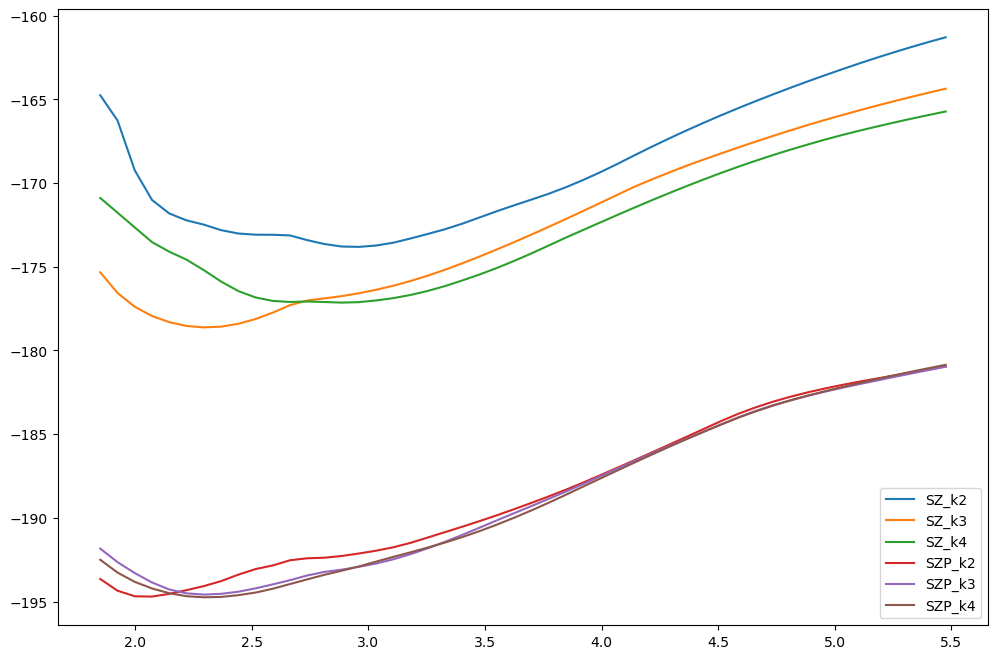

In [ ]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "SZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()

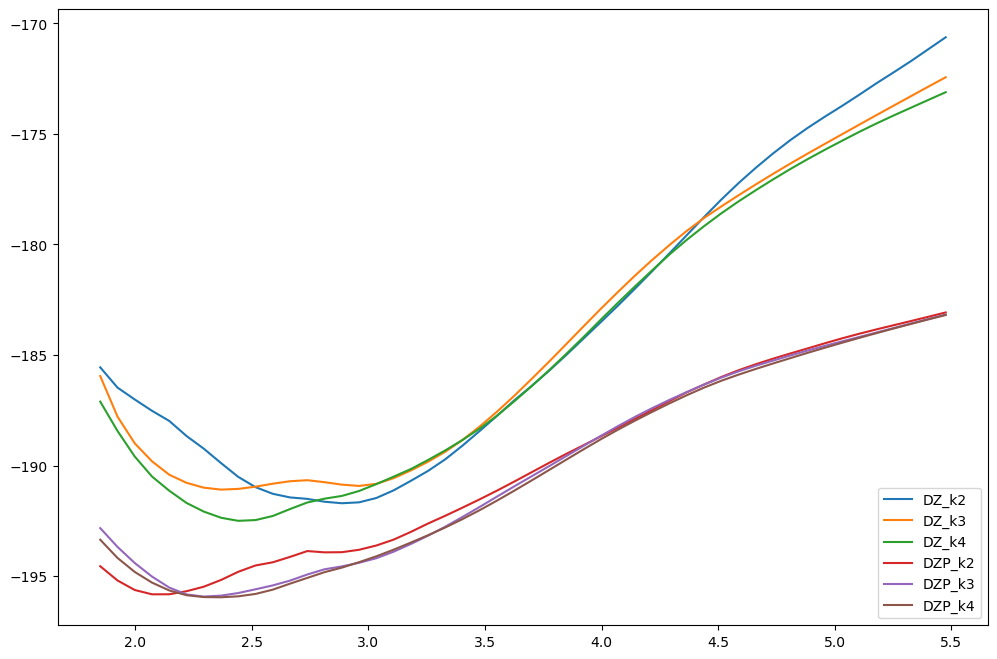

In [14]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "DZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()

## LiC12

In [21]:
# define strains
strains = np.arange(-0.5, 0.5, 0.02)
xyz_path = "./testing/xyz/"
fdf_path = "./testing/fdf/"
system_name = "LiC12"

# generate strained structures
structures = {}
for strain in strains:
    LiC12 = Structure.from_file('../Pristine_primitiveStructure/LiC12.primitive.cif')
    # LiC6.make_supercell([2,2,2])
    LiC12.apply_strain([0, 0, strain])
    structures[strain] = LiC12
    
c = structures[strains[25]].lattice.c
z_distance = [c * (1+s) for s in strains]
print(c)

7.0229000000000035


In [7]:
# write xyz trajectory for strained structures to visualize
# visually validate with VMD
for strain in strains:
    xyz = XYZ(structures[strain])
    name = f"{xyz_path}LiC12_strained_{round(strain,2)}.xyz"
    xyz.write_file(name)
    test_trj = f"{xyz_path}LiC12_trj.xyz"
    os.system(f"cat {name} >> {test_trj}")
    os.system(f"echo '\n' >> {test_trj}")

os.system(f"obabel {test_trj} -O {xyz_path}babtrj_LiC12.xyz")

50 molecules converted


0

In [8]:
for b in basis:
    for k in meshes:
        create_siesta_inputs(system_name, b, k, head_template, tail_template)

./LiC12_scan/SZ_k2/inputs/
./LiC12_scan/SZ_k3/inputs/
./LiC12_scan/SZ_k4/inputs/
./LiC12_scan/SZP_k2/inputs/
./LiC12_scan/SZP_k3/inputs/
./LiC12_scan/SZP_k4/inputs/
./LiC12_scan/DZ_k2/inputs/
./LiC12_scan/DZ_k3/inputs/
./LiC12_scan/DZ_k4/inputs/
./LiC12_scan/DZP_k2/inputs/
./LiC12_scan/DZP_k3/inputs/
./LiC12_scan/DZP_k4/inputs/


In [23]:
energies = {}
for b in basis:
    for k in meshes:
        energies[f"{b}_k{k}"] = []
        for strain in strains:
            with open(f"../scan_LiC12/{b}_k{k}/outputs/OUT.LiC12.{round(strain,2)}_zStrain") as f:
                for line in f:
                    if "siesta:         Total =" in line:
                        energies[f"{b}_k{k}"].append(float(line.strip().split()[3]))

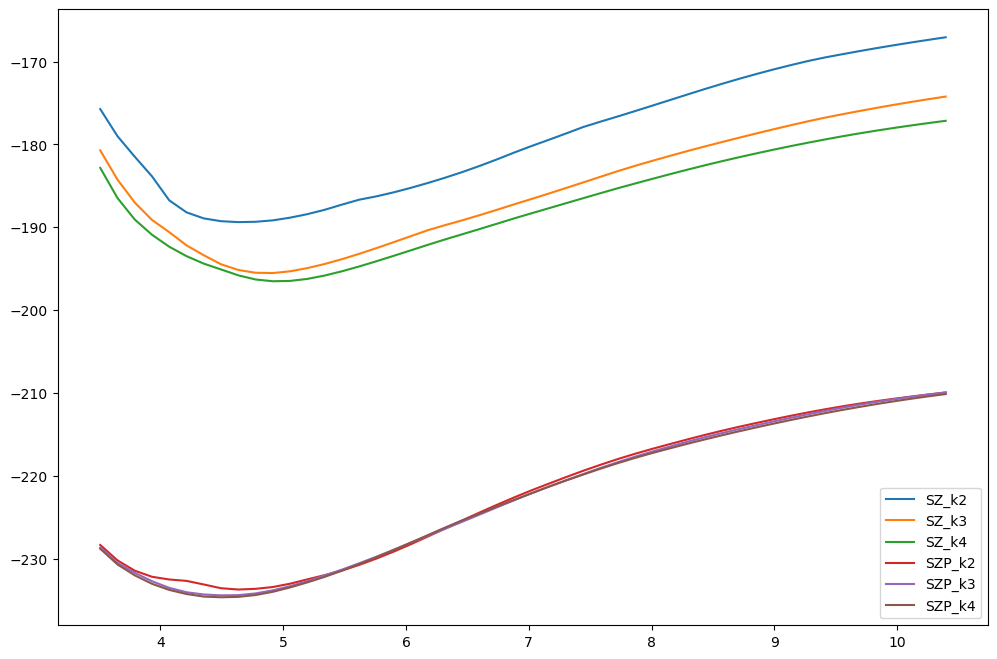

In [24]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "SZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()

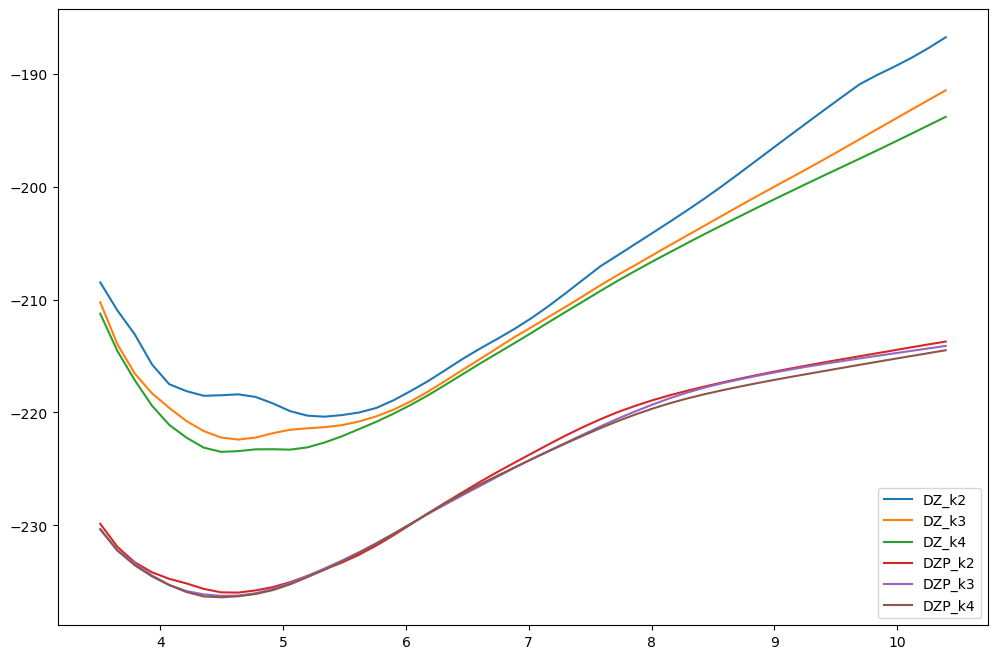

In [25]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "DZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()

## LiC18

In [26]:
# define strains
strains = np.arange(-0.5, 0.5, 0.02)
xyz_path = "./testing/xyz/"
fdf_path = "./testing/fdf/"
system_name = "LiC18"

# generate strained structures
structures = {}
for strain in strains:
    LiC18 = Structure.from_file('../Pristine_primitiveStructure/LiC18.primitive.cif')
    # LiC6.make_supercell([2,2,2])
    LiC18.apply_strain([0, 0, strain])
    structures[strain] = LiC18
    
c = structures[strains[25]].lattice.c
z_distance = [c * (1+s) for s in strains]
print(c)

11.099581000000006


In [10]:
# write xyz trajectory for strained structures to visualize
# visually validate with VMD
for strain in strains:
    xyz = XYZ(structures[strain])
    name = f"{xyz_path}LiC18_strained_{round(strain,2)}.xyz"
    xyz.write_file(name)
    test_trj = f"{xyz_path}LiC18_trj.xyz"
    os.system(f"cat {name} >> {test_trj}")
    os.system(f"echo '\n' >> {test_trj}")

os.system(f"obabel {test_trj} -O {xyz_path}babtrj_LiC18.xyz")

50 molecules converted


0

In [11]:
for b in basis:
    for k in meshes:
        create_siesta_inputs(system_name, b, k, head_template, tail_template)

./LiC18_scan/SZ_k2/inputs/
./LiC18_scan/SZ_k3/inputs/
./LiC18_scan/SZ_k4/inputs/
./LiC18_scan/SZP_k2/inputs/
./LiC18_scan/SZP_k3/inputs/
./LiC18_scan/SZP_k4/inputs/
./LiC18_scan/DZ_k2/inputs/
./LiC18_scan/DZ_k3/inputs/
./LiC18_scan/DZ_k4/inputs/
./LiC18_scan/DZP_k2/inputs/
./LiC18_scan/DZP_k3/inputs/
./LiC18_scan/DZP_k4/inputs/


In [27]:
energies = {}
for b in basis:
    for k in meshes:
        energies[f"{b}_k{k}"] = []
        for strain in strains:
            with open(f"../scan_LiC18/{b}_k{k}/outputs/OUT.LiC18.{round(strain,2)}_zStrain") as f:
                for line in f:
                    if "siesta:         Total =" in line:
                        energies[f"{b}_k{k}"].append(float(line.strip().split()[3]))

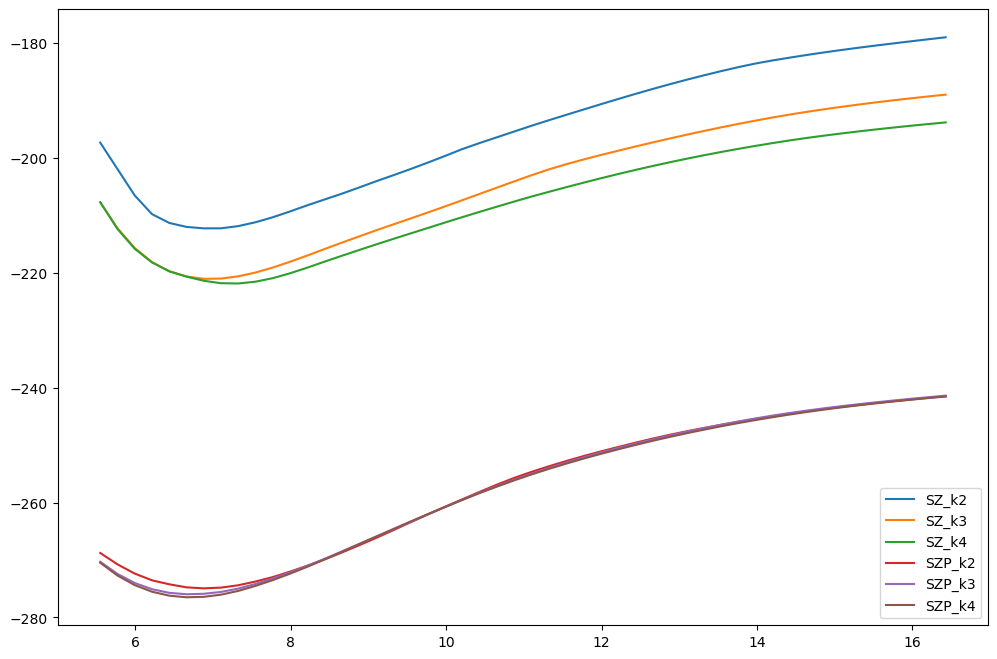

In [28]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "SZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()

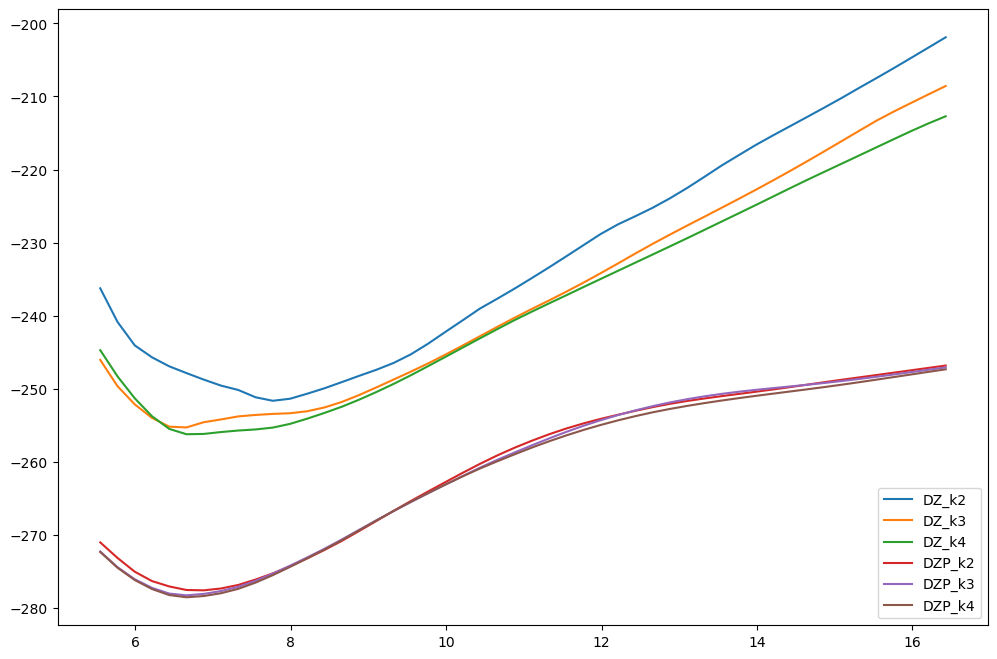

In [29]:
plt.figure(figsize=(12,8))
for condition in energies:
    if "DZ" in condition:
        plt.plot(z_distance, energies[condition], label=condition)
plt.legend(loc="lower right")
plt.show()